In [1]:
import os
import copy as _cp
import numpy as _np
import matplotlib.pyplot as plt
import matplotlib.ticker

import hadronic
import electron
import load_data

%config InlineBackend.figure_format = 'retina'

# Hadronic EDM limits

## Load Data

Data is saved in plaint text files with the following format:  
&emsp; column 1: publication year  
&emsp; column 2: EDM limit in [e\*cm]  
&emsp; column 3: reference key, which is the first author's last name and year of publication

In [2]:
neutron_EDMs = load_data.hadronic("neutron")
tlf_EDMs = load_data.hadronic("TlF")
hg_EDMs = load_data.hadronic("Hg")
xe_EDMs = load_data.hadronic("Xe")
ra_EDMs = load_data.hadronic("Ra")
yb_EDMs = load_data.hadronic("Yb")

In [3]:
class Plottables:
    def __init__(self, EDMs):
        """
        Attributes:
            years
            edms
            thetas
            cedms
            new_ms
            kwargs: dict, for plotting
        
        Args:
            EDMs, list of EDM instances
        """
        self.years = []
        self.edms = []
        self.thetas = []
        self.cedms = []
        self.new_ms = []
        self.populate_lists(EDMs=EDMs)
        self.kwargs = None
    
    def populate_lists(self, EDMs):
        for edm in EDMs:
            self.years.append(edm.year)
            self.edms.append(edm.edm_e_cm)
            self.thetas.append(edm.theta_QCD)
            self.cedms.append(edm.cEDM)
            self.new_ms.append(edm.new_particle_mass_from_cEDM)

            
def save_figures(fig, plot_title):
    """Save pdf and png versions
    
    Args:
        fig: matplotlib Figure instance
        plot_title: str
    """
    plot_name = plot_title + ".pdf"
    plot_path = os.path.join("plots", plot_name)
    fig.savefig(plot_path, bbox_inches='tight')
    plot_name = plot_title + ".png"
    plot_path = os.path.join("plots", plot_name)
    fig.set_facecolor('w')
    fig.savefig(plot_path, dpi=300, transparent=False, bbox_inches='tight')            


# Marker styles
n_kwargs = {'marker':"o", 'color':"royalblue", 'label':"neutron", 
            's':100, 'edgecolor':"b"}
hg_kwargs = {'marker':"*", 'color':"orange", 'label':"Hg", 
            's':100, 'edgecolor':"darkorange"}
xe_kwargs = {'marker':"s", 'color':"indianred", 'label':"Xe", 
            's':100, 'edgecolor':"darkred"}
tlf_kwargs = {'marker':"d", 'color':"yellow", 'label':"TlF", 
            's':100, 'edgecolor':"gold"}
ra_kwargs = {'marker':"x", 'color':"darkgreen", 'label':"Ra", 
            's':100}
yb_kwargs = {'marker':"D", 'color':"darkgray", 'label':"Yb", 
            's':100}

n_vals = Plottables(neutron_EDMs)
n_vals.kwargs = n_kwargs
hg_vals = Plottables(hg_EDMs)
hg_vals.kwargs = hg_kwargs
xe_vals = Plottables(xe_EDMs)
xe_vals.kwargs = xe_kwargs
tlf_vals = Plottables(tlf_EDMs)
tlf_vals.kwargs = tlf_kwargs
ra_vals = Plottables(ra_EDMs)
ra_vals.kwargs = ra_kwargs
yb_vals = Plottables(yb_EDMs)
yb_vals.kwargs = yb_kwargs

hadronic_systems = [n_vals, hg_vals, xe_vals, tlf_vals, ra_vals, yb_vals]

year_i = 1945
year_f = 2024
year_i_electron = 1955
year_f_electron = 2025

ma_alpha = 0.6
mi_alpha = 0.1


In [4]:
def scatter_plot_loop(ax, systems, value):
    """
    
    Args:
        ax: matplotlib type, "ax"
        systems: list, systems with data to plot
        value: str, type of value to plot.
    """
    for system in systems:
        ax.scatter(system.years, getattr(system, value), **system.kwargs)

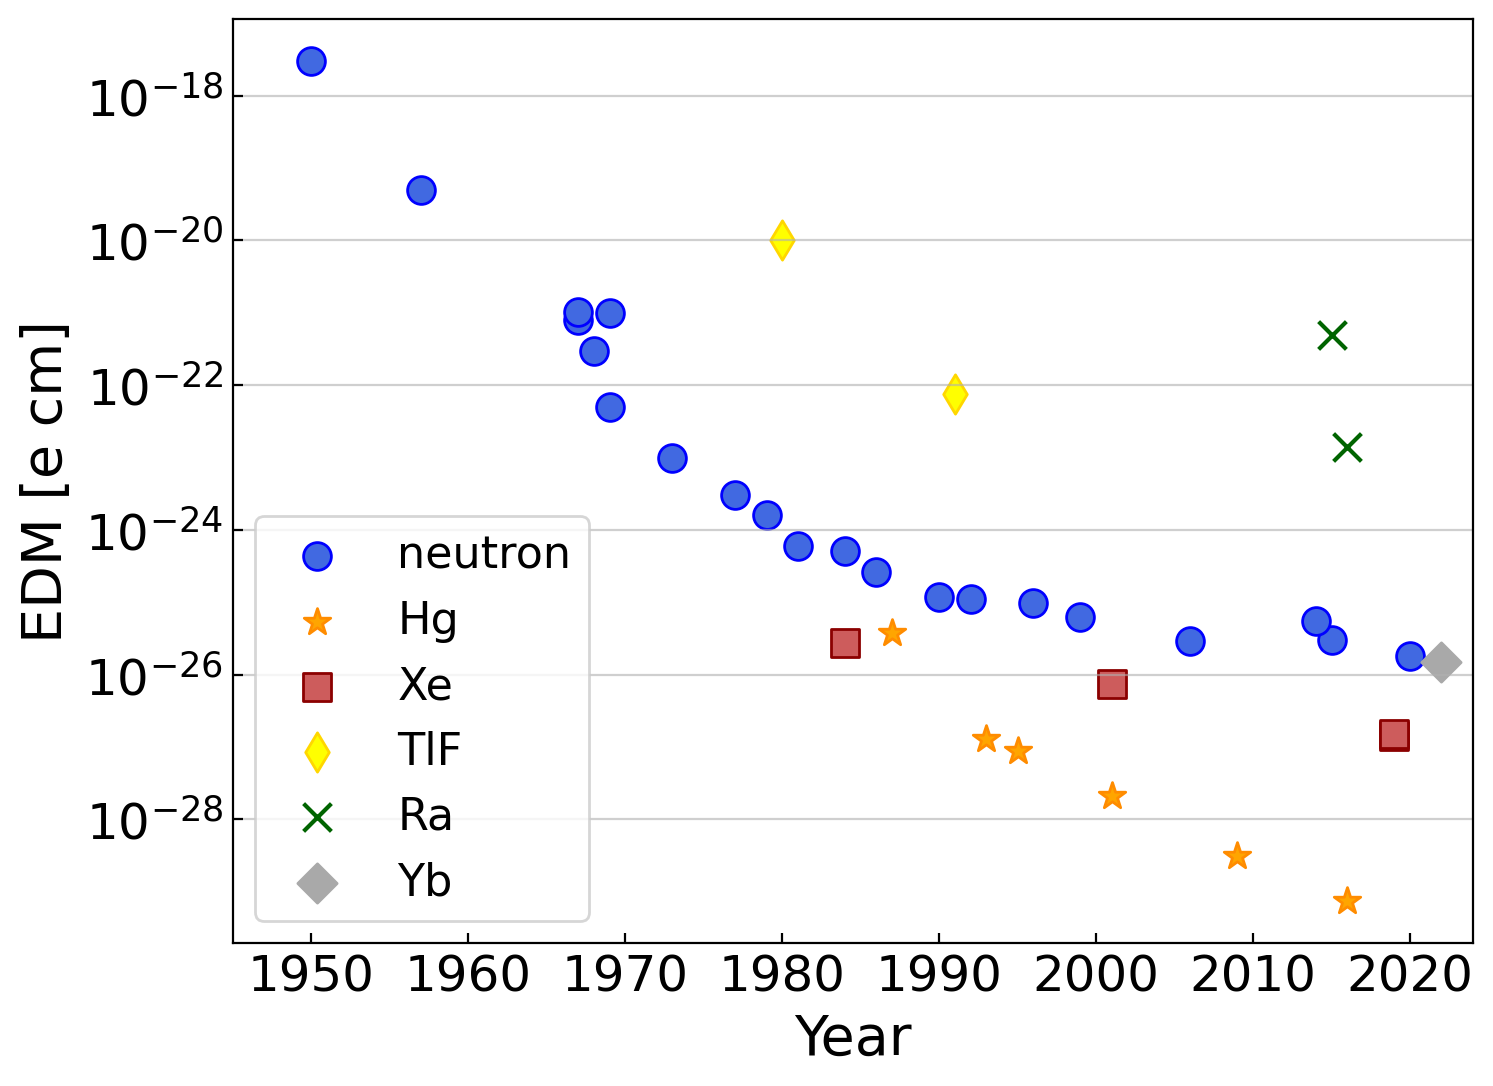

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, hadronic_systems, "edms")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("EDM [e cm]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=16)#, framealpha=1)

save_figures(fig=fig, plot_title="hadronic-edm-limits")

### Theta QCD bounds

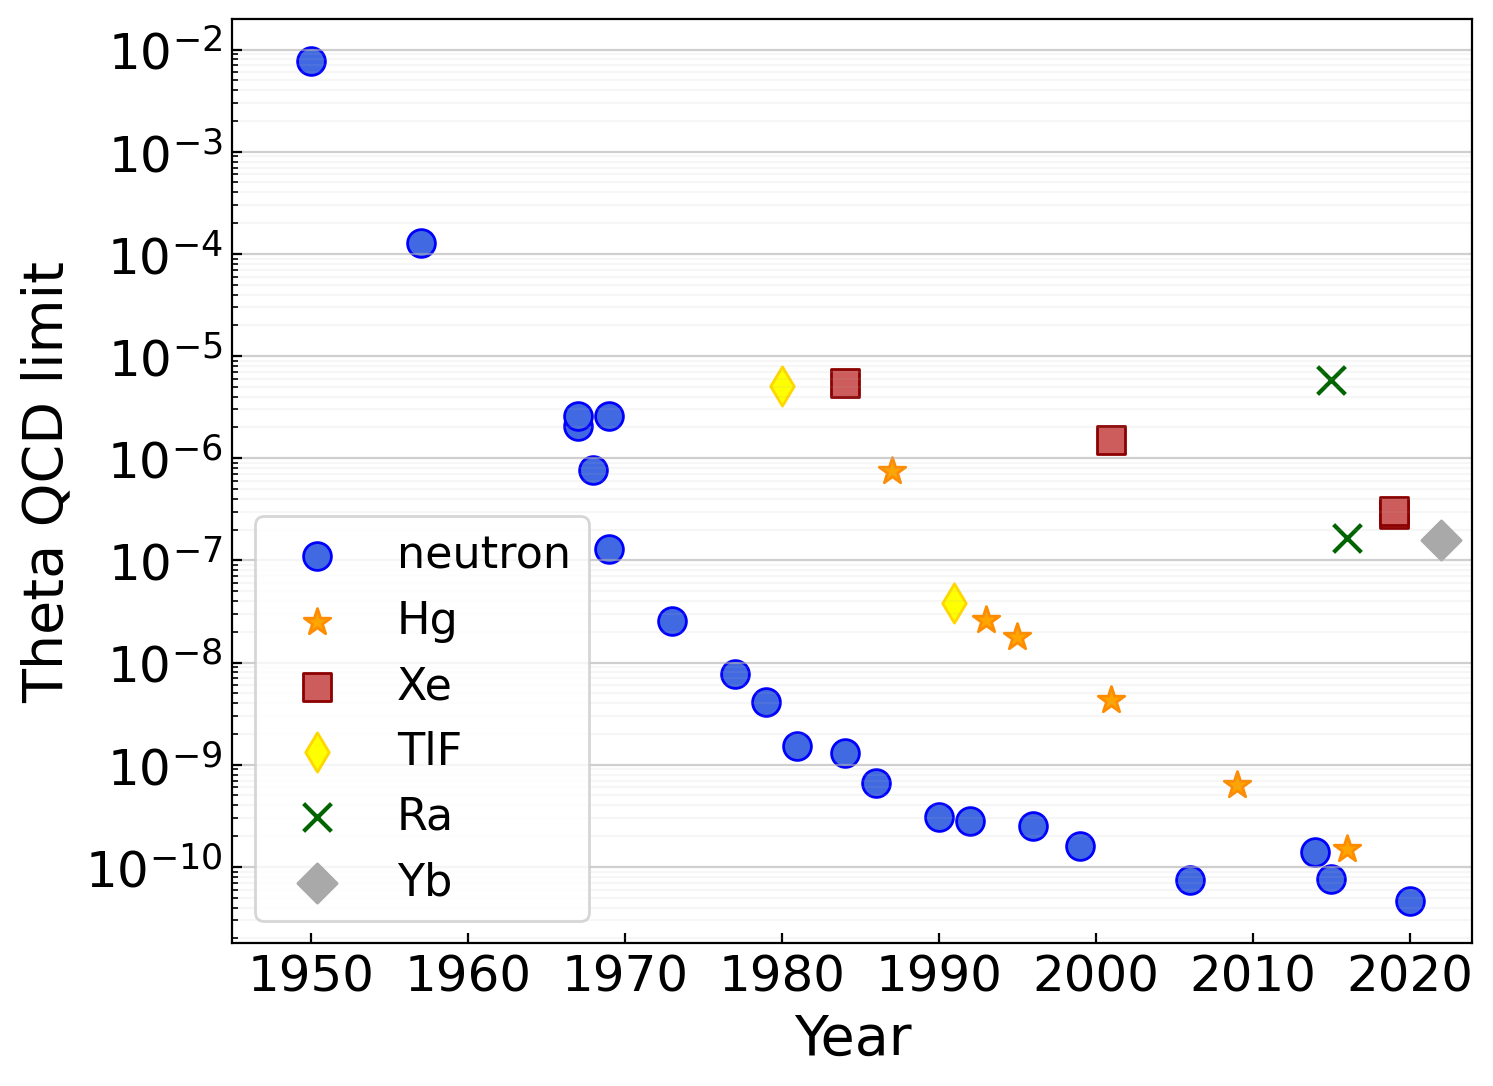

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter_plot_loop(ax, hadronic_systems, "thetas")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)
ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)
fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Theta QCD limit", fontsize=fontsize)
plt.legend(loc='lower left', fontsize=16)

save_figures(fig=fig, plot_title="theta-qcd-limits")

### Quark chromo EDM bounds

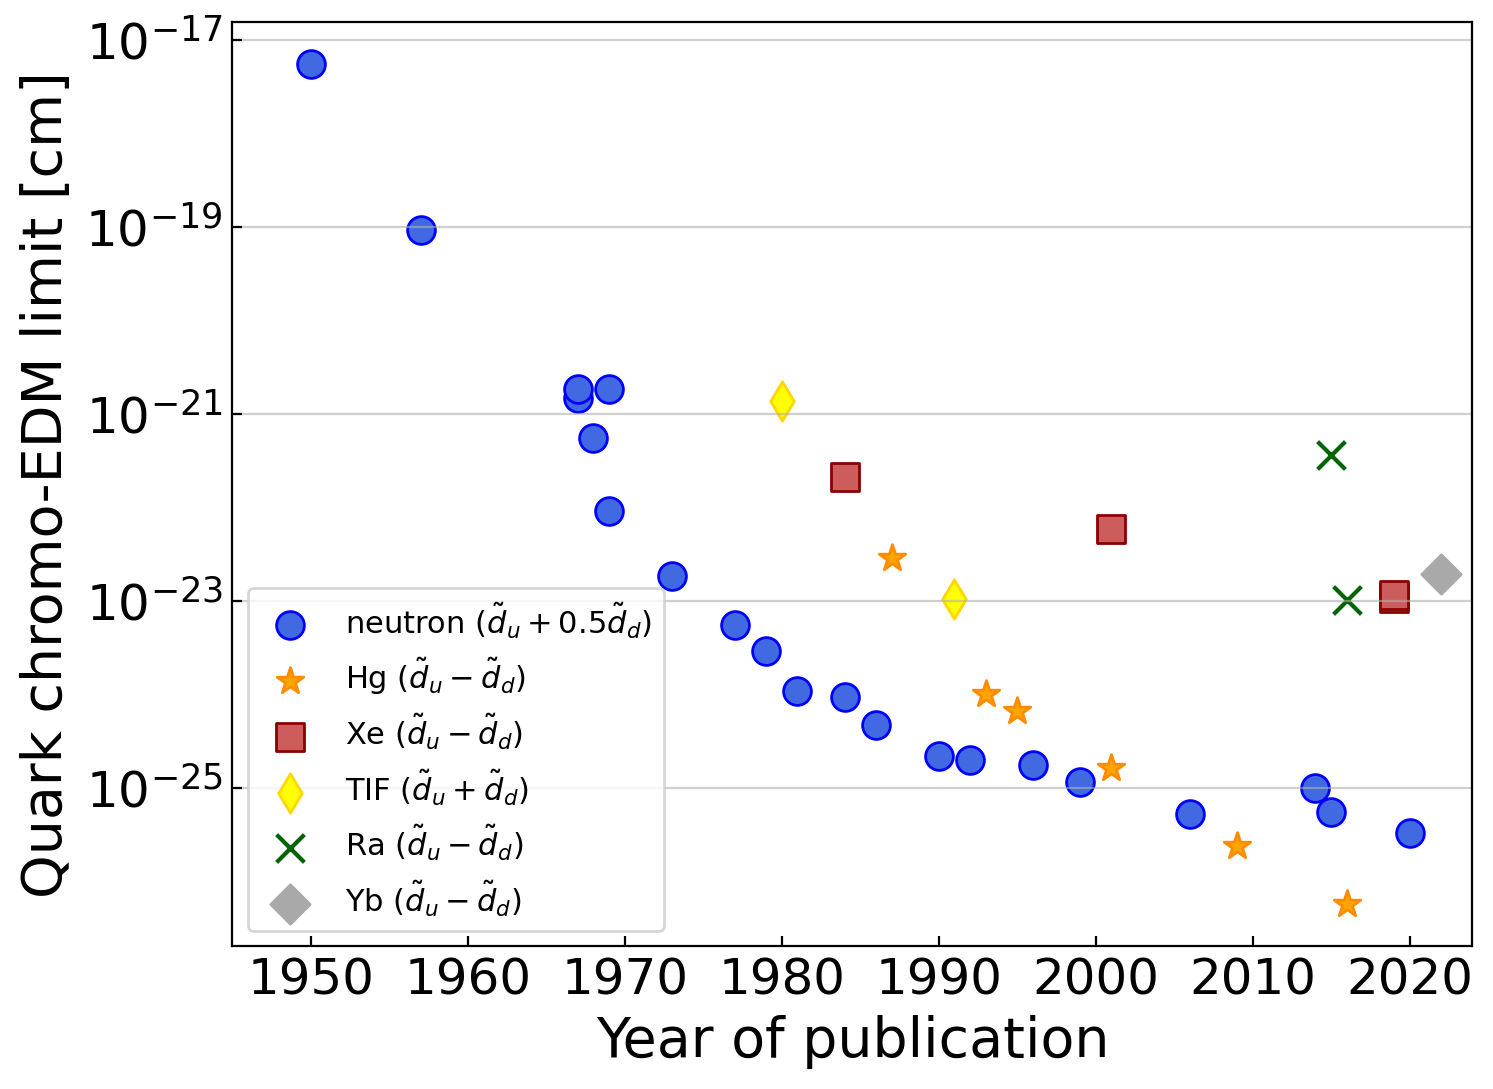

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

n_q_kwargs = _cp.deepcopy(n_kwargs)
n_q_kwargs['label'] = r"neutron ($\tilde{d}_u+0.5\tilde{d}_d$)"

hg_q_kwargs = _cp.deepcopy(hg_kwargs)
hg_q_kwargs['label'] = r"Hg ($\tilde{d}_u-\tilde{d}_d$)"

xe_q_kwargs = _cp.deepcopy(xe_kwargs)
xe_q_kwargs['label'] = r"Xe ($\tilde{d}_u-\tilde{d}_d$)"

tlf_q_kwargs = _cp.deepcopy(tlf_kwargs)
tlf_q_kwargs['label'] = r"TIF ($\tilde{d}_u+\tilde{d}_d$)"

ra_q_kwargs = _cp.deepcopy(ra_kwargs)
ra_q_kwargs['label'] = r"Ra ($\tilde{d}_u-\tilde{d}_d$)"

yb_q_kwargs = _cp.deepcopy(yb_kwargs)
yb_q_kwargs['label'] = r"Yb ($\tilde{d}_u-\tilde{d}_d$)"

ax.scatter(n_vals.years, n_vals.cedms, **n_q_kwargs)
ax.scatter(hg_vals.years, hg_vals.cedms, **hg_q_kwargs)
ax.scatter(xe_vals.years, xe_vals.cedms, **xe_q_kwargs)
ax.scatter(tlf_vals.years, tlf_vals.cedms, **tlf_q_kwargs)
ax.scatter(ra_vals.years, ra_vals.cedms, **ra_q_kwargs)
ax.scatter(yb_vals.years, yb_vals.cedms, **yb_q_kwargs)

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)
ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)
fontsize = 20
ax.set_xlabel("Year of publication", fontsize=fontsize)
ax.set_ylabel(r"Quark chromo-EDM limit [cm]", fontsize=fontsize)
plt.legend(loc='lower left', fontsize=11)

save_figures(fig=fig, plot_title="quark-chromo-edm-limits")

### New particle mass sensitivity from chromo EDM bounds

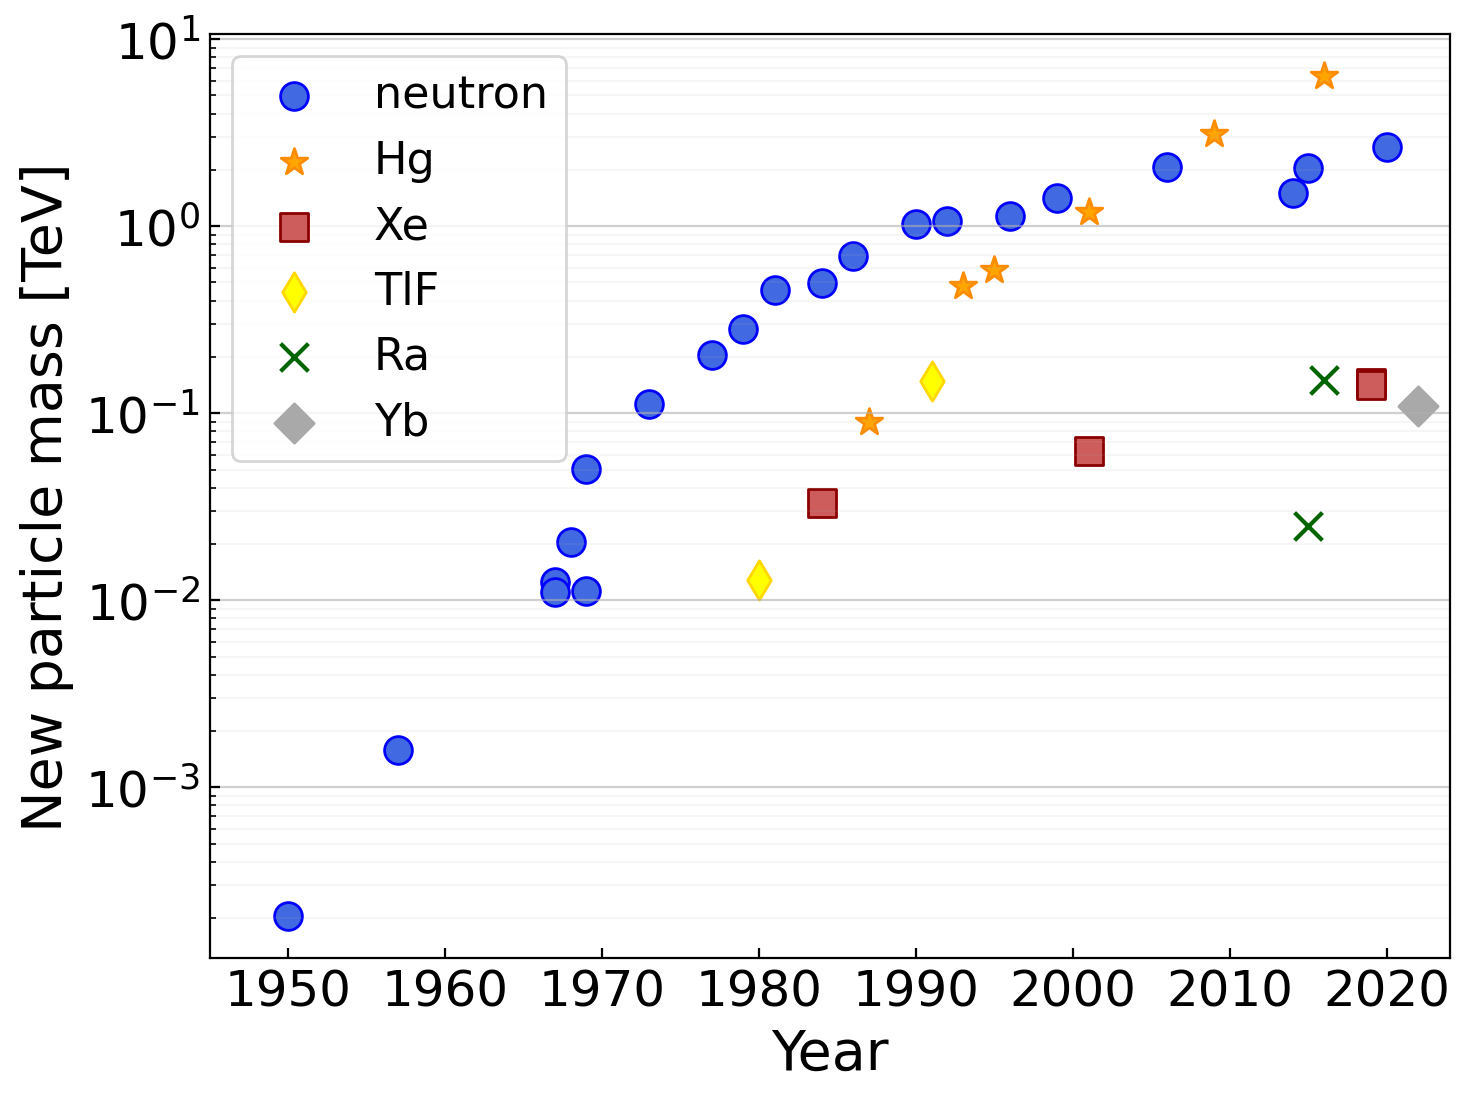

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
marker_size = 100

scatter_plot_loop(ax, hadronic_systems, "new_ms")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_ylabel("New particle mass [TeV]", fontsize=fontsize)
ax.set_xlabel("Year", fontsize=fontsize)
plt.legend(loc='upper left', fontsize=16)

save_figures(fig=fig, plot_title="new-particle-limits")

# Electron EDM limits

### Load data

In [9]:
HfF = load_data.electron(file_name="HfF.txt")
ThO = load_data.electron(file_name="ThO.txt")
PbO = load_data.electron(file_name="PbO.txt")
YbF = load_data.electron(file_name="YbF.txt")
TlF_eEDM = load_data.electron(file_name="TlF.txt")
Tl = load_data.electron(file_name="Tl.txt")
Hg_eEDM = load_data.electron(file_name="Hg.txt")
Xe_eEDM = load_data.electron(file_name="Xe.txt")
Rb = load_data.electron(file_name="Rb.txt")
Cs = load_data.electron(file_name="Cs.txt")
He = load_data.electron(file_name="He.txt")
Lamb = load_data.electron(file_name="Lamb.txt")
g_factor = load_data.electron(file_name="g_factor.txt")

In [10]:
class ElectronPlottables:
    def __init__(self, eEDMs):
        """
        Attributes:
            edms, 
        
        Args:
            eEDMs, list of EDM instances
        """
        self.years = []
        self.edms = []
        self.one_loop = []
        self.two_loop = []
        self.populate_lists(EDMs=eEDMs)
        self.kwargs = None
    
    def populate_lists(self, EDMs):
        for edm in EDMs:
            self.years.append(edm.year)
            self.edms.append(edm.edm_e_cm)
            one_loop = edm.one_loop_mass_limit
            self.one_loop.append(one_loop)
            two_loop = edm.two_loop_mass_limit
            self.two_loop.append(two_loop)
            

HfF_kwargs = {'marker':"d", 'color':"hotpink", 'label':"HfF+", 
            's':100, 'edgecolor':"crimson"}
ThO_kwargs = {'marker':"o", 'color':"yellowgreen", 'label':"ThO", 
            's':100, 'edgecolor':"darkgreen"}
He_kwargs = {'marker':"D", 'color':"yellowgreen", 'label':"He scattering", 
            's':100, 'edgecolor':"green"}
PbO_kwargs = {'marker':">", 'color':"purple", 'label':"PbO", 
            's':100, 'edgecolor':"indigo"}
YbF_kwargs = {'marker':"X", 'color':"cyan", 'label':"YbF", 
            's':100, 'edgecolor':"darkcyan"}
Tl_kwargs = {'marker':"s", 'color':"royalblue", 'label':"Tl", 's':100, 'edgecolor':"b"}
Rb_kwargs = {'marker':"H", 'color':"thistle", 'label':"Rb", 
            's':100, 'edgecolor':"violet"}
Cs_kwargs = {'marker':"<", 'color':"grey", 'label':"Cs", 
            's':100, 'edgecolor':"black"}
Lamb_kwargs = {'marker':"p", 'color':"peru", 'label':"Lamb shift", 
            's':100, 'edgecolor':"sienna"}
g_factor_kwargs = {'marker':"^", 'color':"orange", 'label':"g factor", 
            's':100, 'edgecolor':"orange"}
            
HfF_vals = ElectronPlottables(HfF)
HfF_vals.kwargs = HfF_kwargs
ThO_vals = ElectronPlottables(ThO)
ThO_vals.kwargs = ThO_kwargs
PbO_vals = ElectronPlottables(PbO)
PbO_vals.kwargs = PbO_kwargs
YbF_vals = ElectronPlottables(YbF)
YbF_vals.kwargs = YbF_kwargs
TlF_eEDM_vals = ElectronPlottables(TlF_eEDM)
TlF_eEDM_vals.kwargs = tlf_vals.kwargs
Tl_vals = ElectronPlottables(Tl)
Tl_vals.kwargs = Tl_kwargs
Hg_eEDM_vals = ElectronPlottables(Hg_eEDM)
Hg_eEDM_vals.kwargs = hg_vals.kwargs
Xe_eEDM_vals = ElectronPlottables(Xe_eEDM)
Xe_eEDM_vals.kwargs = xe_vals.kwargs
Rb_vals = ElectronPlottables(Rb)
Rb_vals.kwargs = Rb_kwargs
Cs_vals = ElectronPlottables(Cs)
Cs_vals.kwargs = Cs_kwargs
He_vals = ElectronPlottables(He)
He_vals.kwargs = He_kwargs
Lamb_vals = ElectronPlottables(Lamb)
Lamb_vals.kwargs = Lamb_kwargs
g_factor_vals = ElectronPlottables(g_factor)
g_factor_vals.kwargs = g_factor_kwargs

electron_systems = [HfF_vals, ThO_vals, PbO_vals, YbF_vals, TlF_eEDM_vals, Tl_vals, Hg_eEDM_vals, 
                   Xe_eEDM_vals, Rb_vals, Cs_vals, He_vals, Lamb_vals, g_factor_vals]

# electron EDM Limits

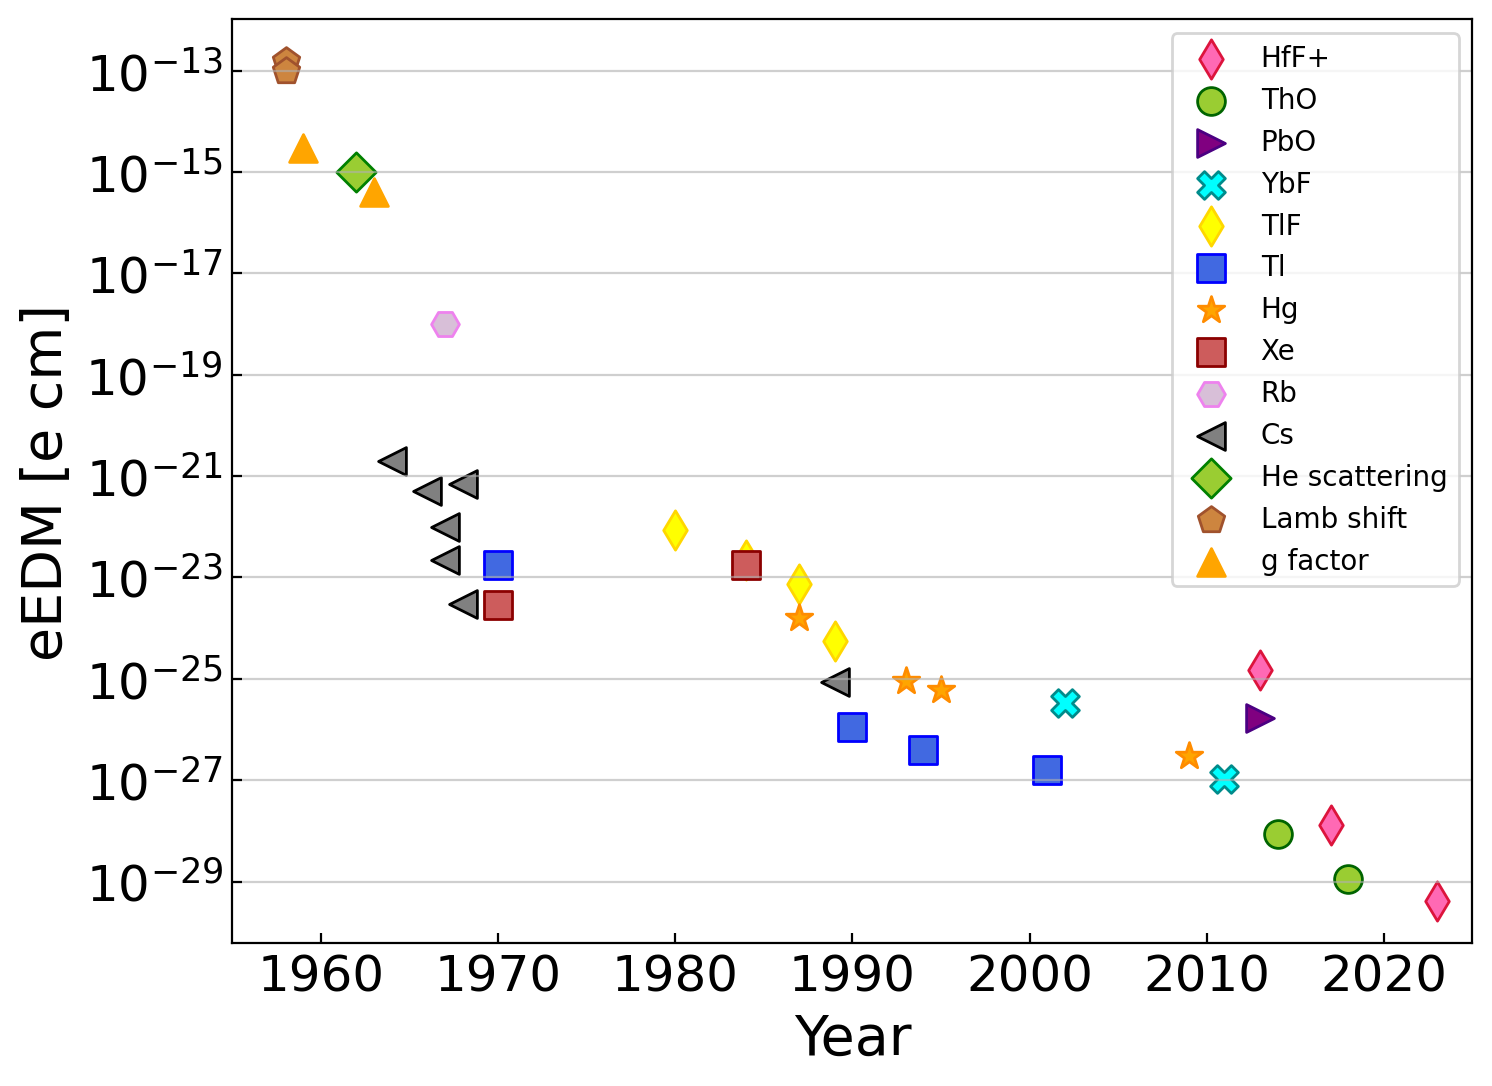

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, electron_systems, "edms")

ax.set_yscale("log")
ax.set_xlim(year_i_electron, year_f_electron)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("eEDM [e cm]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=10)

save_figures(fig=fig, plot_title="electron-edm-limits")

### Single loop limits for new particle masses

Single and two loop particle mass reach limits are from Table 1 of https://arxiv.org/pdf/2203.08103.pdf

One loop mass = 48 TeV $ \times \sqrt{10^{-29} \ \mathrm{e \ cm}/d_\text{e}}$  
Two loop mass = 2 TeV $ \times \sqrt{10^{-29} \ \mathrm{e \ cm}/d_\text{e}}$  

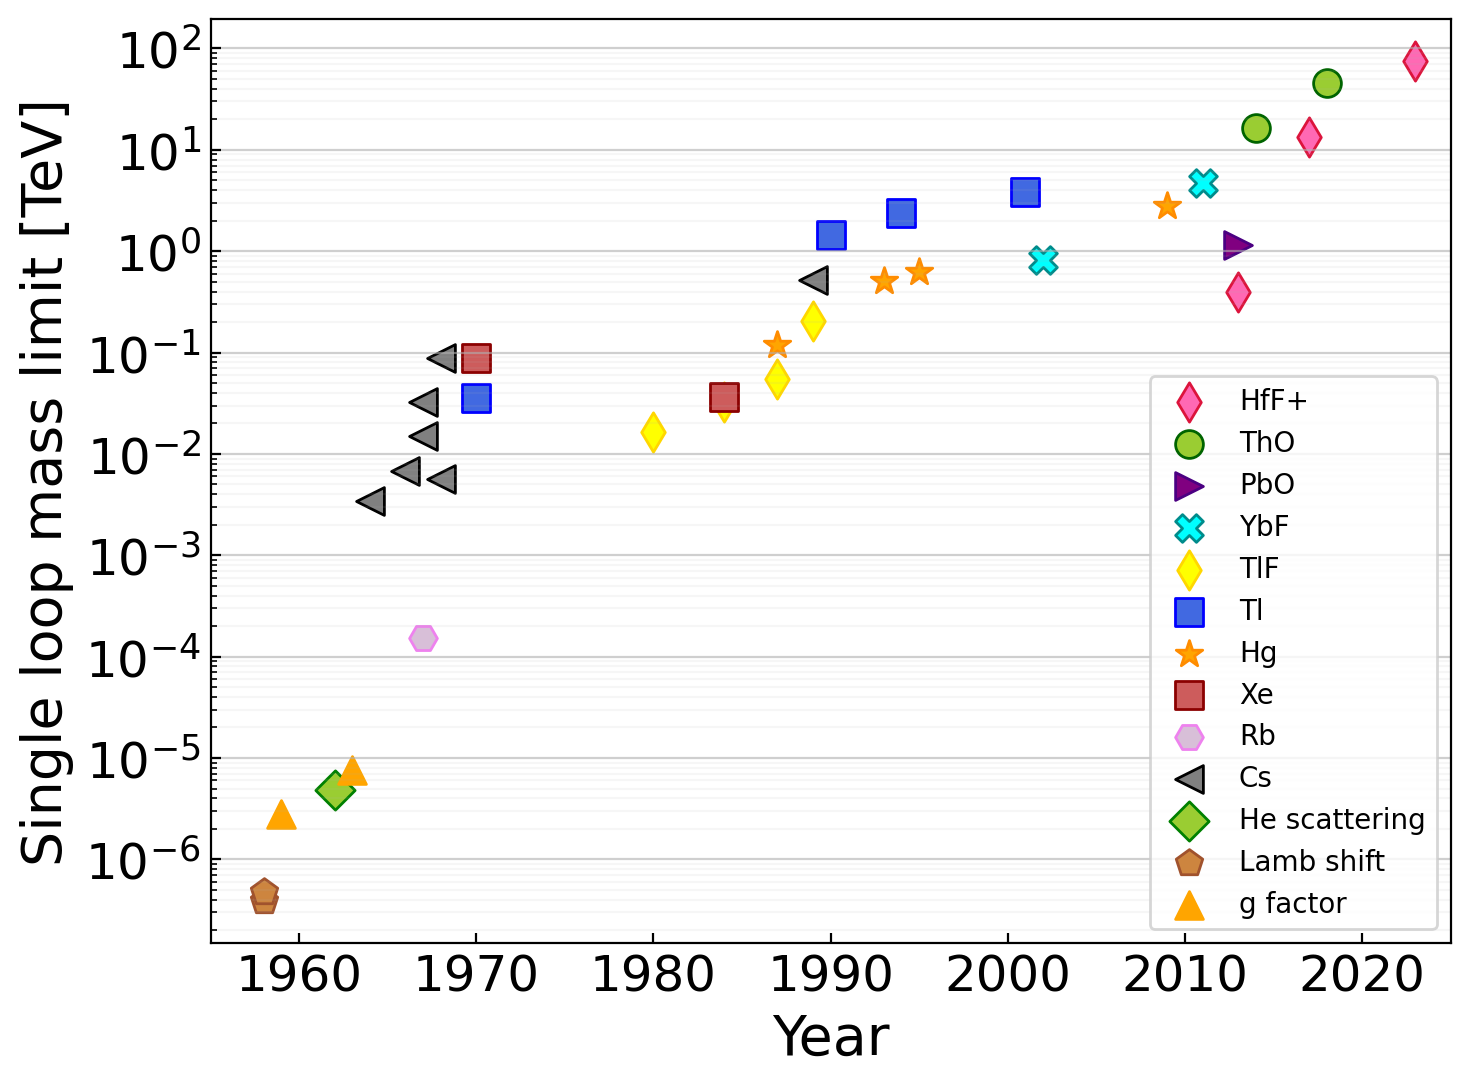

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, electron_systems, "one_loop")

ax.set_yscale("log")
ax.set_xlim(year_i_electron, year_f_electron)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Single loop mass limit [TeV]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=10)#, framealpha=1)

save_figures(fig=fig, plot_title="e-edm-1-loop")

### Two loop limits for new particle masses

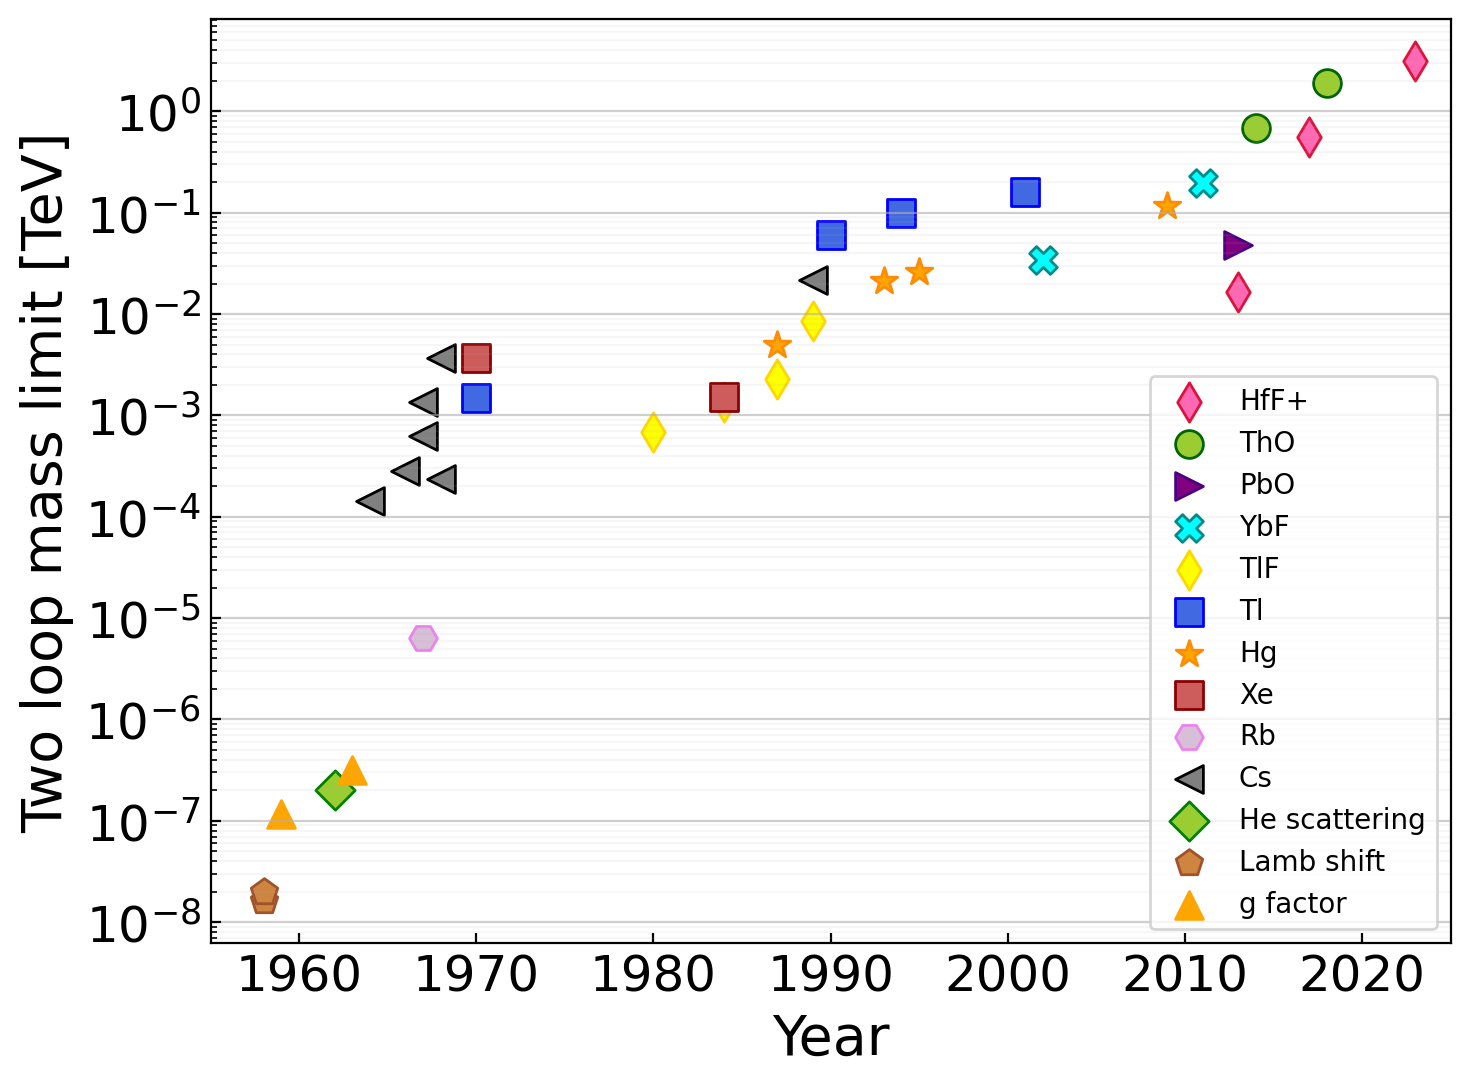

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, electron_systems, "two_loop")

ax.set_yscale("log")
ax.set_xlim(year_i_electron, year_f_electron)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Two loop mass limit [TeV]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=10)

save_figures(fig=fig, plot_title="e-edm-2-loop")